In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from sklearn.decomposition import PCA

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#Load Model
pretrained_model = "Early_Work_RH/data/lenet_mnist_model.pth"
model = Net()
model = model.to(device)
model.load_state_dict(torch.load(pretrained_model))
model.eval()
print(model)

#Load Second Model With last Linear Layer Deleted
model2 = Net()
model2 = model2.to(device)
model2.load_state_dict(torch.load(pretrained_model))
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return F.relu(x)
model2.fc2 = Identity()
model2.eval()
print(model2)

#Data Set
data_set = torchvision.datasets.MNIST('Early_Work_RH/data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
            ]))

dl = torch.utils.data.DataLoader(data_set, batch_size=1, shuffle=False)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Identity()
)


In [5]:
def BIM_test(model, device, dl, epsilon, alpha, steps):
    images = []
    adversarial_images = []
    correct = 0
    
    for img, label in dl:
        img, label = img.to(device), label.to(device)

        curr_img = img
        curr_img.requires_grad = True
        output = model(curr_img)

        if output.max(1, keepdim=True)[1] != label:
            continue
        
        images.append((img.cpu(), label.cpu()))
        for i in range(steps):
            loss = F.cross_entropy(output, label)

            model.zero_grad()
            loss.backward()

            data_grad = curr_img.grad.data.sign()

            perturbed_image = img + (alpha*data_grad)

            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            total_grad = perturbed_image - img

            total_grad = torch.clamp(total_grad, -epsilon, epsilon)

            perturbed_image = img + total_grad

            curr_img = perturbed_image.clone().detach()

            curr_img.requires_grad = True

            output = model(curr_img)
        
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        final_pred = output.max(1, keepdim=True)[1]

        if final_pred == label:
            correct += 1
        else:
            adversarial_images.append((perturbed_image.cpu(), label.cpu()))
        
    return correct/len(dl), adversarial_images, images

In [26]:
epsilon = .5
alpha = .25
num_steps = 5
accuracy, adv_imgs, test_images = BIM_test(model, device, dl, epsilon, alpha, num_steps)

In [27]:
print(accuracy)
print(len(adv_imgs))
print(len(test_images))

0.1162
8648
9810


In [49]:
outputs = np.empty((len(test_images) + len(adv_imgs), 50))
labels = []
x=0
for img, label in test_images:
    img = img.to(device)
    output = model2(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(str(label.item()))
    x += 1

for img, label in adv_imgs:
    img = img.to(device)
    output = model2(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(str(label.item()))
    x += 1

print(outputs.shape)
print(len(labels))
print(x)

(18458, 50)
18458
18458


In [76]:
#Fit with all data
pca1 = PCA(n_components=2)
pca1_data = pca1.fit_transform(outputs)
df1 = pd.DataFrame(data = pca1_data
             , columns = ['principal component 1', 'principal component 2'])

#Fit with real images
pca2 = PCA(n_components=2)
pca2.fit(outputs[:9810])
pca2_data = pca2.transform(outputs)
df2 = pd.DataFrame(data = pca2_data
             , columns = ['principal component 1', 'principal component 2'])

#Fit with adversarial images
pca3 = PCA(n_components=2)
pca3.fit(outputs[9810:])
pca3_data = pca3.transform(outputs)
df3 = pd.DataFrame(data = pca3_data
             , columns = ['principal component 1', 'principal component 2'])

hue_order =["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

<Figure size 4320x1440 with 0 Axes>

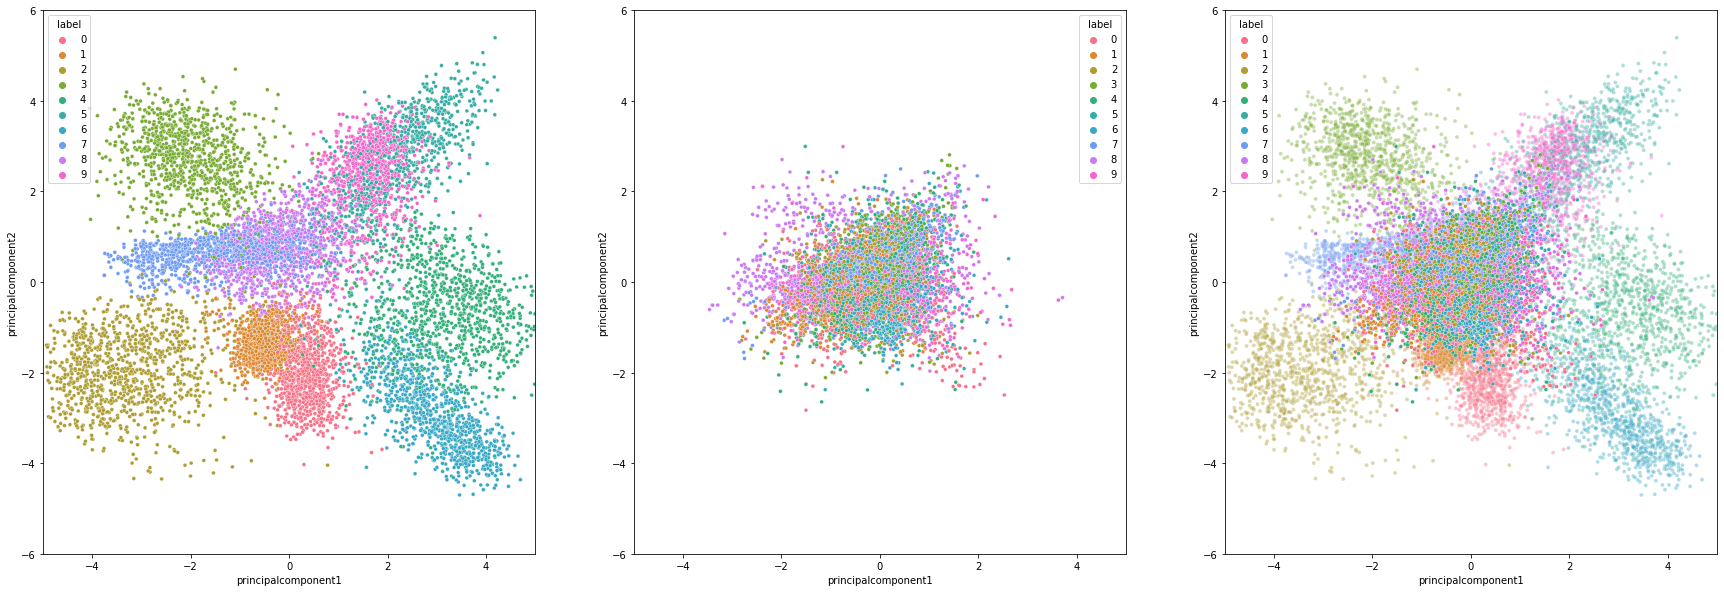

<Figure size 4320x1440 with 0 Axes>

In [88]:
#Fitted with both normal and adversarial images
principalDf = pd.concat([df1,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]


fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig = plt.gcf()
fig.set_size_inches(30,10)

ax1.set_xlim([-5, 5])
ax1.set_ylim([-6, 6])
ax2.set_xlim([-5, 5])
ax2.set_ylim([-6, 6])
ax3.set_xlim([-5, 5])
ax3.set_ylim([-6, 6])

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9810], s = 15, hue_order=hue_order,
           hue='label', legend=True, ax=ax1)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9810:], s = 15, hue_order=hue_order,
           hue='label', legend=True, ax=ax2)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9810], s = 15, alpha = .4, hue_order=hue_order,
           hue='label', legend=True, ax=ax3)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9810:], s = 15, alpha = 1, hue_order=hue_order,
           hue='label', legend=False, ax=ax3)


plt.figure(figsize=(60,20))

<Figure size 4320x1440 with 0 Axes>

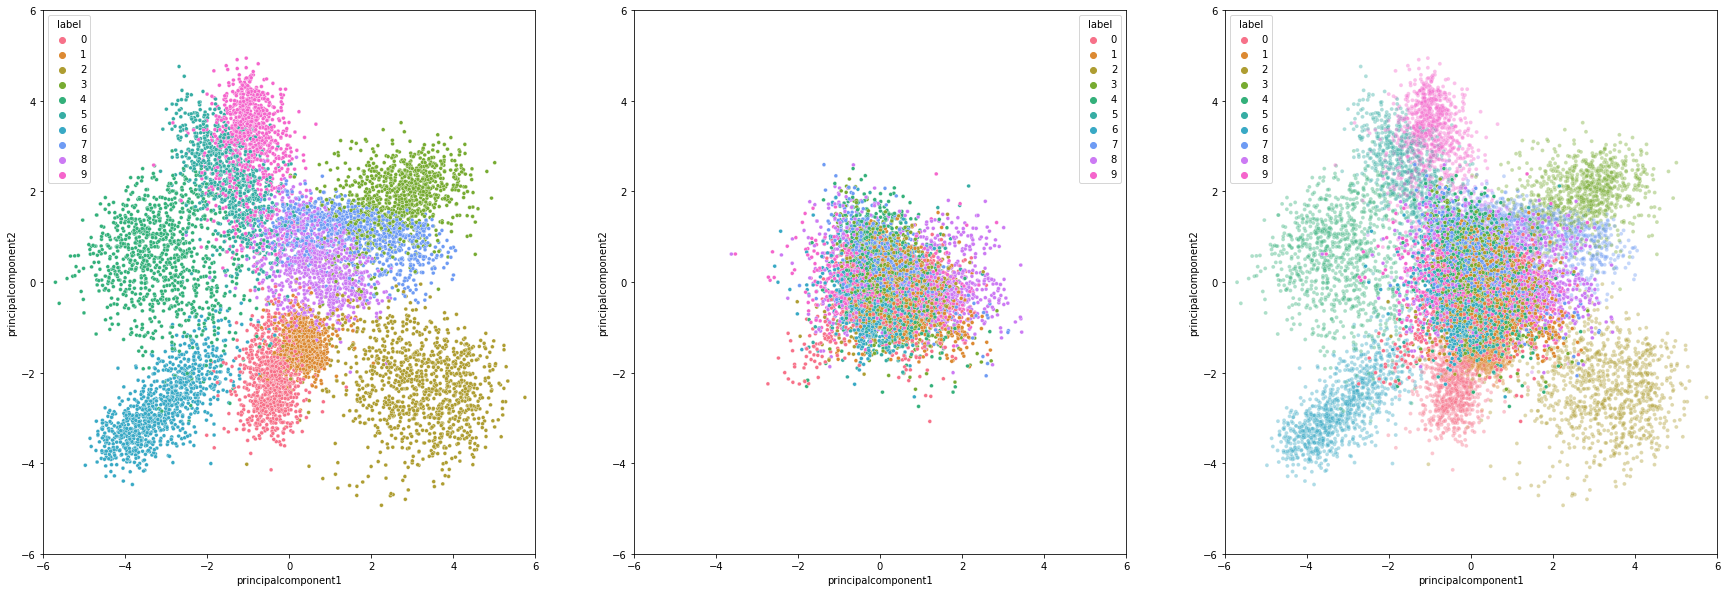

<Figure size 4320x1440 with 0 Axes>

In [89]:
#Fitted with normal images only
principalDf = pd.concat([df2,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]


fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig = plt.gcf()
fig.set_size_inches(30,10)

ax1.set_xlim([-6, 6])
ax1.set_ylim([-6, 6])
ax2.set_xlim([-6, 6])
ax2.set_ylim([-6, 6])
ax3.set_xlim([-6, 6])
ax3.set_ylim([-6, 6])

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9810], s = 15, hue_order=hue_order,
           hue='label', legend=True, ax=ax1)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9810:], s = 15, hue_order=hue_order,
           hue='label', legend=True, ax=ax2)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9810], s = 15, alpha = .4, hue_order=hue_order,
           hue='label', legend=True, ax=ax3)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9810:], s = 15, alpha = 1, hue_order=hue_order,
           hue='label', legend=False, ax=ax3)


plt.figure(figsize=(60,20))

<Figure size 4320x1440 with 0 Axes>

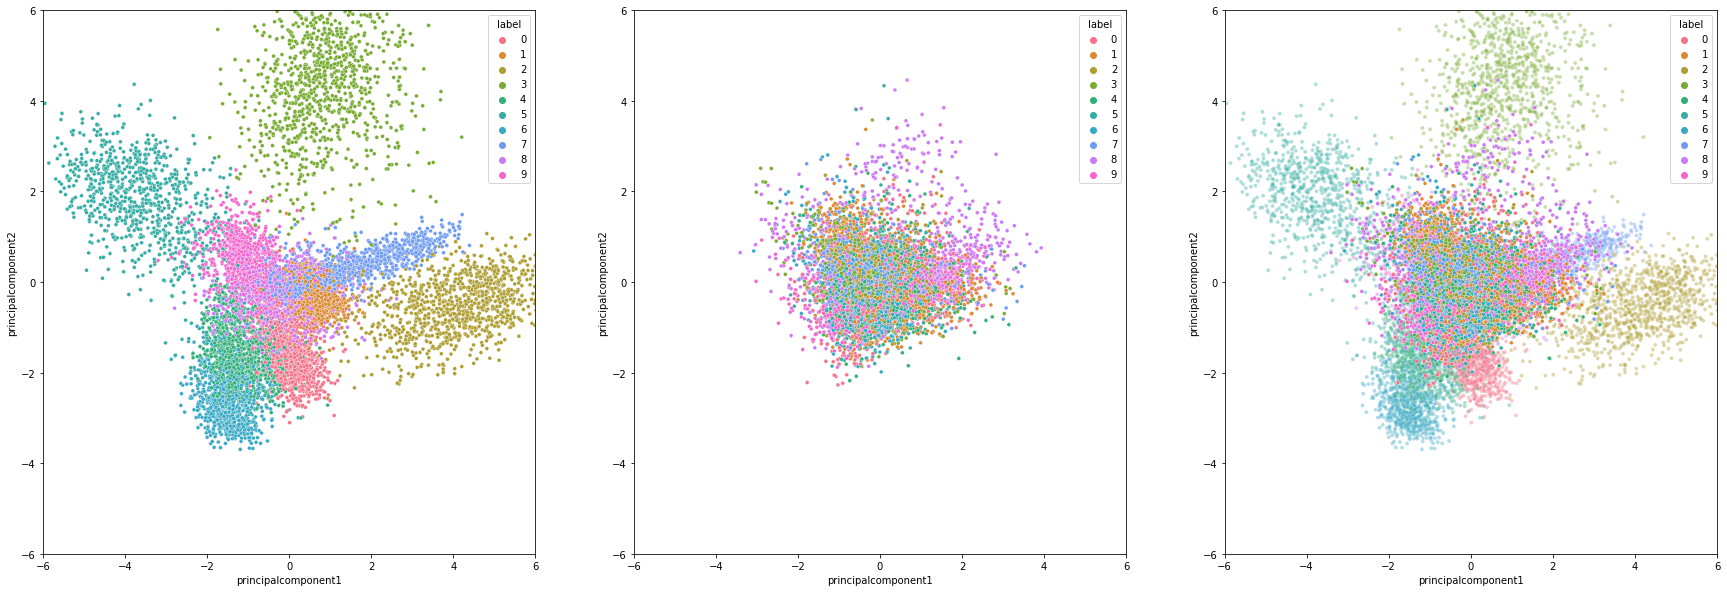

<Figure size 4320x1440 with 0 Axes>

In [90]:
#Fitted with adversarial images only
principalDf = pd.concat([df3,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]


fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig = plt.gcf()
fig.set_size_inches(30,10)

ax1.set_xlim([-6, 6])
ax1.set_ylim([-6, 6])
ax2.set_xlim([-6, 6])
ax2.set_ylim([-6, 6])
ax3.set_xlim([-6, 6])
ax3.set_ylim([-6, 6])

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9810], s = 15, hue_order=hue_order,
           hue='label', legend=True, ax=ax1)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9810:], s = 15, hue_order=hue_order,
           hue='label', legend=True, ax=ax2)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9810], s = 15, alpha = .4, hue_order=hue_order,
           hue='label', legend=True, ax=ax3)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9810:], s = 15, alpha = 1, hue_order=hue_order,
           hue='label', legend=False, ax=ax3)


plt.figure(figsize=(60,20))